#### Model "class" - inheriting from nn.Module - can "call" forward with model_obj - wrapping parameters in nn.Parameter() so that can iterate later to update (in fit) 

In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0) #torch seed for random

#### data(blob)

In [3]:
# data

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)

XX_train, XX_val, Y_train, Y_val = train_test_split(data, labels, 
                                                  stratify=labels, random_state=0)
print(XX_train.shape, XX_val.shape, labels.shape)

(750, 2) (250, 2) (1000,)


#### data as torch tensors

In [4]:
XX_train, Y_train, XX_val, Y_val = map(torch.tensor, (XX_train, Y_train, XX_val, Y_val)) 

# map the function to all and return all. - instead of calling on each one by one.

print(XX_train.shape, Y_train.shape)

torch.Size([750, 2]) torch.Size([750])


In [5]:
XX_train = XX_train.float()
Y_train = Y_train.long()  # as its an index.

#### Accuracy

In [6]:
def accuracy(YY_hat, yy):
    pp = torch.argmax(YY_hat, dim=1) #prediction = max probability
    return (pp == yy).float().mean()


# .float() convert to float.
# pred==y -> bool of correct preds.

### nn.parameter

In [7]:
import torch.nn as nn

inheriting from a parent class. 

parent class in paranthesis in class definition.

and in init class call super().init -> like calling constructor of parent class.  

### Make a model class; inherit from nn.Module

In [8]:
# class for model

class ModelClass(nn.Module):  # inherit from nn.Module class(parent)
    def __init__(self):
        
        super().__init__()

        torch.manual_seed(0)

        # making weights, biases as before - but wrapping in nn.Parameter()
        # so model knows that they are parameters.
        # don't need explicit req_grad
        self.Wmat1 = nn.Parameter(torch.randn(2, 2) / np.sqrt(2))
        self.Bvec1 = nn.Parameter(torch.zeros(2))
        self.Wmat2 = nn.Parameter(torch.randn(2, 4) / np.sqrt(2))
        self.Bvec2 = nn.Parameter(torch.zeros(4))

    def forward(self, XX):  # same as before
        AA1 = torch.matmul(XX, self.Wmat1) + self.Bvec1
        HH1 = AA1.sigmoid()
        AA2 = torch.matmul(HH1, self.Wmat2) + self.Bvec2
        HH2 = AA2.exp() / AA2.exp().sum(-1).unsqueeze(-1)
        return HH2

inherited from nn.Module

making a object - calling it like a function on something - calls the 'forward' function.  
ie, **model_obj(X) -> is alias for model_obj.forward(X)**.  
this is because of the **\_\_call__** magic method which is defined in the parent (nn.Module)

thats how nn.Module is written. 

##### seperately wrinting fit function (not in class.)

In [9]:
import torch.nn.functional as F

In [10]:
def fit(epochs=1000, learning_rate=1):
    loss_arr = []
    acc_arr = []
    
    # through each epoch
    for epoch in range(epochs):
        
        # fn is object of above class(to be made.)
        # calling fn like a fn - call forward function
        # because it inherited from nn.Module.
        # forward pass
        YY_hat = model_obj(XX_train)
        # using some 'global' model_obj

        # loss
        loss = F.cross_entropy(YY_hat, Y_train)
        
        # logging
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(YY_hat, Y_train))

        # gradient
        loss.backward()
        
        # update parameters
        # before - we manually wrote update lines for each parameters.
        # now doing it in better way using nn.Parameters
        with torch.no_grad():
            for param in model_obj.parameters():
                param -= learning_rate * param.grad
            model_obj.zero_grad()  # set all gradients(of all params) to 0.

        ## nn.Parameters - provide short hand for updating parameters
        ## and reseting gradients to 0.

    plt.plot(loss_arr, "r-")
    plt.plot(acc_arr, "b-")
    plt.show()
    print("Loss before training", loss_arr[0])
    print("Loss after training", loss_arr[-1])


# now the fit function doesn't have to care about how many sets
# of weights and biases are there in the model, because all of them
# are wrapped in parameters - they can be iterated over in fit.
# any number of sets is ok.


wrapping in nn.Parameters() - all added to an iterator - which can be iterated over and updated without having to use the specific names,etc. Similarly can set all grad attributes to 0 with a single function.  
one layer of easy abstraction.

**fit function can remain independent of the model**  
not assuming any knowledge of the model above in fit()  

same thing - for any model

this is design template in the framework.  
keep fit "function" as a core function - and pass on to it the model, optimizer, hyper parameters, etc. 

good programming style.  

**model (object) has parameters and forward()**  

**autograd tracks all operations - whether they are using functions, or are on class attributes, etc **  
  
parameter updation  - done outside computation graph (no_grad)

**The advantage of using an independent fit function is that the same fit function can be used for all the projects - only model, loss, etc. be changed**

**MODEL "CLASS", FIT "FUNCTION"**  
loss function, etc.  

**model object has parameters and forward()**

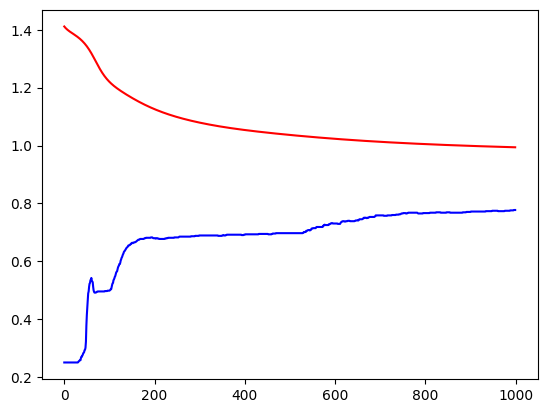

Loss before training 1.4111982583999634
Loss after training 0.9939236044883728


In [11]:
model_obj = ModelClass()
fit()

here fit is accesssing a 'global' model_obj. In general model is passed to the fit function.